### Submitted by Coral Ifergan

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
print(cv2.__version__)

4.4.0


## Step I: Stabilize a rotating video filmed by a drone

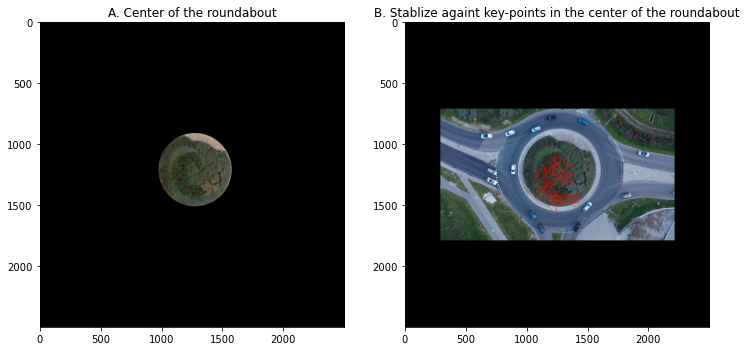

In [3]:
mask = np.zeros(F_c.shape, dtype=np.uint8)
mask = cv2.circle(mask, (1270, 1210), 300, (255,255,255), -1) 
result = cv2.bitwise_and(F_c, mask)

canvas = F_c.copy()
for i in range(len(pts0)-500):
    x= pts0[i][0][0].squeeze().astype(np.int)
    y= pts0[i][0][1].squeeze().astype(np.int)
    canvas = cv2.circle(canvas,(x,y),4,(0,0,255),-1) 
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.title('A. Center of the roundabout')
plt.imshow(result,cmap='gray')

plt.subplot(1,2,2)
plt.title('B. Stablize againt key-points in the center of the roundabout')
plt.imshow(canvas)
plt.show()

In [2]:
cap = cv2.VideoCapture('P1_roundabout.mp4')

# Params for key-points detection
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.001,
                       minDistance = 10,
                       blockSize = 5 )

# Parameters for optical flow
lk_params = dict( winSize  = (50,50), 
                  maxLevel = 5, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


ret, F0 = cap.read()
canvas = F0.copy()
N = 2500 # borders size 
w0 = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h0 = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
F0 = cv2.copyMakeBorder(F0, np.int((N-h0)/2), np.int((N-h0)/2), np.int((N-w0)/2), np.int((N-w0)/2), cv2.BORDER_CONSTANT)
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
h,w = F0_gray.shape
F_c=F0.copy()

#Create a circular mask to capture key-points only from the center of the roundabout (which ara still and stable)
circular_mask = np.zeros(F0_gray.shape, dtype=np.uint8)
circular_mask = cv2.circle(circular_mask, (1270, 1210), 300, (255,255,255), -1) 


#Find the corner points with the applied mask
pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = circular_mask, **feature_params)
pts_ref = pts0.copy()

FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX') # or just copy it from the original video
out = cv2.VideoWriter('P1_roundabout_stab.mp4',fourcc, FPS, (w,h)) # (W,H) should be integers

while True:
    # Read next frame
    ret, F1 = cap.read() 
    if ret==True:
        F1 = cv2.copyMakeBorder(F1, np.int((N-h0)/2), np.int((N-h0)/2), np.int((N-w0)/2), np.int((N-w0)/2), cv2.BORDER_CONSTANT)
        F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow
        pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)
        
        # Delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        pts_ref = pts_ref[status[:,0]==1]
       
        
        # Find homogrpahy and warp perspective
        H,_ = cv2.findHomography(pts1, pts_ref, cv2.RANSAC,50.0)
        F1_warp = cv2.warpPerspective(F1, H, (w,h))
        
  
        #Update the previous frame and previous points
        F0_gray = F1_gray
        pts0 = pts1
        
        # Visualize and save result
        cv2.imshow('WINDOW_NAME', F1_warp) 
        out.write(F1_warp)

        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
    else:
        break

cap.release() 
out.release()
cv2.destroyAllWindows() 
cv2.waitKey(1);

## Step II: Detect, track and assign a unique ID for each of the vehicles

#### Vehicle Detection and Tracking Pipeline (by image proccessing)

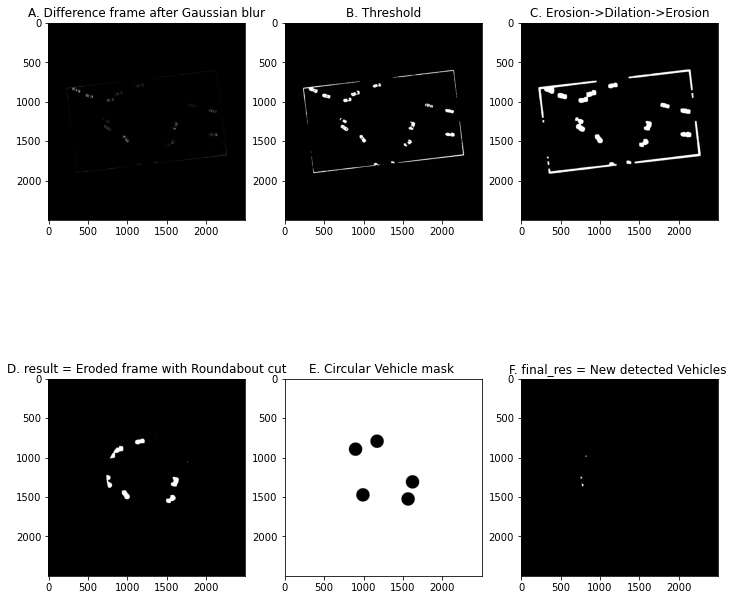

In [5]:
plt.figure(figsize=(12,12))
plt.subplot(2,3,1)
plt.title('A. Difference frame after Gaussian blur')
plt.imshow(diff_blur,cmap='gray')

plt.subplot(2,3,2)
plt.title('B. Threshold')
plt.imshow(thresh,cmap='gray')

plt.subplot(2,3,3)
plt.title('C. Erosion->Dilation->Erosion')
plt.imshow(erosion,cmap='gray')

plt.subplot(2,3,4)
plt.title('D. result = Eroded frame with Roundabout cut')
plt.imshow(result,cmap='gray')

plt.subplot(2,3,5)
plt.title('E. Circular Vehicle mask ')
plt.imshow(vehicle_mask,cmap='gray')

plt.subplot(2,3,6)
plt.title('F. final_res = New detected Vehicles ')
plt.imshow(final_res,cmap='gray')
plt.show()

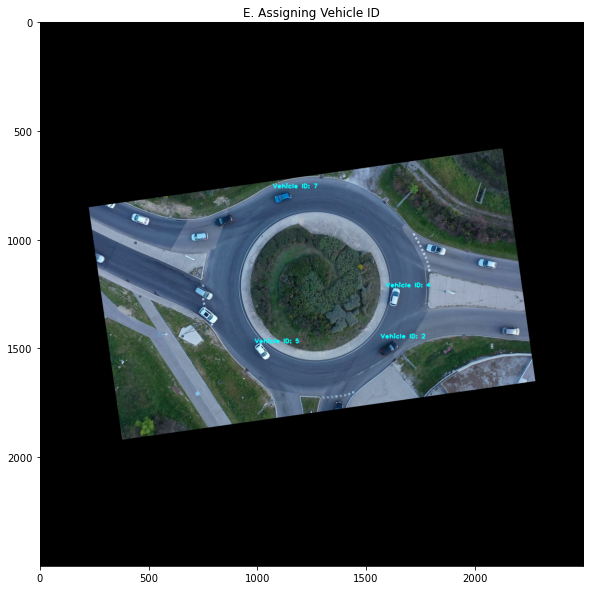

In [6]:
F0_c = cv2.cvtColor(F0_c, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title('E. Assigning Vehicle ID')
plt.imshow(F0_c)
plt.show()

In [7]:
cap = cv2.VideoCapture('P1_roundabout_stab.mp4')

FPS = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'DIVX') 
out = cv2.VideoWriter('Vehicle_detection_tracking.mp4',fourcc, FPS, (w,h)) 

# Parameters for key-points detection
feature_params = dict( maxCorners = 15,
                       qualityLevel = 0.001,
                       minDistance = 1,
                       blockSize = 6 )

# Parameters for optical flow
lk_params = dict( winSize  = (50,50), 
                  maxLevel = 5, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))



# Font parameters
font_params = dict(fontFace = cv2.FONT_HERSHEY_PLAIN,
                   fontScale = 2,
                   color = (255,255,0),
                   thickness=3,
                   lineType = 1000)

#First frame
ret, F0 = cap.read() 
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)

frame_counter=0
vehicle_points_list=[]
vehicle_id_list=[]
id_count=1

vehicle_mask=np.zeros_like(F0_gray)
vehicle_mask = cv2.cvtColor(vehicle_mask, cv2.COLOR_GRAY2RGB)
vehicle_mask[:,:,:]=255
circular_mask = np.zeros(F0_gray.shape, dtype=np.uint8)
circular_mask = cv2.circle(circular_mask, (1270, 1220), 530, (255,255,255), -1) 

while True:
    # Read next frame
    ret, F1 = cap.read() 
    
    if ret==True:
        F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)

        #Calculates optical flow of vehicle keypoints
        for i in range(len(vehicle_points_list)): 
            if vehicle_points_list[i] is not None and len(vehicle_points_list[i])>0:
                pts0=vehicle_points_list[i]
                
                #The mid point among all key-points of a vehicle
                x_avg=np.average(vehicle_points_list[i][:,0,0]).astype(np.int)
                y_avg=np.average(vehicle_points_list[i][:,0,1]).astype(np.int)
                
                #If the vehicle is inside the roundabout, calculate Optical Flow
                if(np.square(x_avg-1270)+ np.square(y_avg-1220))<np.square(530):

                    # Update the key points with OpticalFlow
                    pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)
                    
                    # Delete the "failed" points (status==0)
                    pts1 = pts1[status[:,0]==1]
                    pts0 = pts0[status[:,0]==1]
                    pts2=[]
                    
                    #Only save the key points that are not left behind the vehicle; k coressponds to the index of the individual key-point
                    #(x-x_avg)^2+(y-y_avg)^2<r^2:
                    #Small circle: if a key point is outside that circle, stop tracking it
                    for k in range(len(pts1)):
                        if (np.square(pts1[k][0][0]-x_avg)+ np.square(pts1[k][0][1]-y_avg))<np.square(25):
                            pts2.append(pts1[k])
                    pts1=np.array(pts2)
               
                #For the vehicles that we stop tracking, put an empty list in the vehicle_points_list so that the vehicle indices 
                #dont get mixed-up with IDs later
                else:
                    pts1=[]
               
                vehicle_points_list[i]=pts1
        
        F0_c=np.copy(F0)
        
        #Re-detect every 10 frames
        if frame_counter%10==0:

            F0_blur = cv2.GaussianBlur(F0_gray,(0,0),1)
            F1_blur = cv2.GaussianBlur(F1_gray,(0,0),1)

            diff_blur = cv2.absdiff(F0_blur, F1_blur)
            blur_diff_blur = cv2.GaussianBlur(diff_blur,(0,0),3)
            ret, thresh = cv2.threshold(blur_diff_blur, 5, 100, cv2.THRESH_BINARY)   
            kernel = np.ones((5,5),np.uint8)
            erosion = cv2.erode(thresh, kernel)
            kernel = np.ones((7,7),np.uint8)
            dilated = cv2.dilate(erosion,kernel,iterations=6)
            kernel = np.ones((5,5),np.uint8)
            erosion = cv2.erode(dilated, kernel,iterations=4)
            
            #Pick out only what's inside the roundabout
            result = cv2.bitwise_and(erosion, erosion,mask=circular_mask)
            
            #Intialize vehicles mask (not assigning final value yet)
            vehicle_mask=np.zeros_like(F0_gray)
            vehicle_mask = cv2.cvtColor(vehicle_mask, cv2.COLOR_GRAY2RGB)
            
            #The vehicles will be masked in black later
            vehicle_mask[:,:,:]=255
            
            #For every-already detected vehicle, mask it out by applying a circular black mask on top of it 
            for i in range(len(vehicle_points_list)):
                if vehicle_points_list[i] is not None and len(vehicle_points_list[i])>0:
                    
                    #(Current keypoints): Find the center of vehicle key-points and apply circular mask around it
                    x_avg=np.average(vehicle_points_list[i][:,0,0]).astype(np.int)
                    y_avg=np.average(vehicle_points_list[i][:,0,1]).astype(np.int)
                    
                    #Block a vehicle with a black circle that is bigger than the vehicle
                    cv2.circle(vehicle_mask,(x_avg, y_avg),85,(0,0,0),-1)
                        
            
            vehicle_mask = cv2.cvtColor(vehicle_mask, cv2.COLOR_RGB2GRAY)
            
            #final_res is the roundabout(=vehicle_mask) with currently detected vehicles (=result) blocked out. Visually, only new
            #cars with no assigned-ID will appear in white on a black background.
            final_res = cv2.bitwise_and(result, result,mask=vehicle_mask)
            kernel = np.ones((5,5),np.uint8)
            final_res = cv2.erode(final_res, kernel,iterations=7) 
            
            #Find countours of the new vehicles (=in white)
            ctrs, _ = cv2.findContours(final_res, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
            #Find keypoints in the newly detected vehicles 
            for j in range(len(ctrs)):
                if cv2.contourArea(ctrs[j])>1000:
                    mask=np.zeros_like(F0_gray)
                    x_avg=np.average(ctrs[j][:,0,0]).astype(np.int)
                    y_avg=np.average(ctrs[j][:,0,1]).astype(np.int)
                    
                    #Create a small circular mask aruond the mid point of the vehicle inside which we want to find key-points
                    cv2.circle(mask,(x_avg, y_avg),8,(255,255,255),-1)
                    pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = mask, **feature_params)
                    
                    #Update the vehicle_points_list
                    vehicle_points_list.append(pts0)
                    
                    #Update the vehicle ID list  
                    vehicle_id_list.append('Vehicle ID: '+str(id_count))
                    id_count=id_count+1
        
        #Plot the Vehicle ID for each vehicle if inside the roundabout 
        for l in range(len(vehicle_points_list)):
            if vehicle_points_list[l] is not None and len(vehicle_points_list[l])>0:
                x_avg=np.average(vehicle_points_list[l][:,0,0]).astype(np.int)
                y_avg=np.average(vehicle_points_list[l][:,0,1]).astype(np.int)
                
                if (np.square(x_avg-1270)+ np.square(y_avg-1220))<np.square(530):
                    cv2.putText(F0_c,vehicle_id_list[l],(x_avg-40,y_avg-40),**font_params)
                

        # Mark entrances and exists by ellipses
        overlay = F0_c.copy()
        output = F0_c.copy()
        cv2.ellipse(overlay, (800,970), (106,17), 110, 0,180,(2,16,145),-1)
        cv2.ellipse(overlay, (1120,1700), (73,18), 10, 0,180,(2,16,145),-1)
        cv2.ellipse(overlay, (1757,1397), (88,18), -72, 0,180,(2,16,145),-1)
        cv2.ellipse(overlay, (767,1286), (114,18), 79, 0,180,(255,255,255),-1)
        cv2.ellipse(overlay, (1372,1710), (80,18), -8, 0,180,(255,255,255),-1)
        cv2.ellipse(overlay, (1747,1053), (100,18), -114, 0,180,(255,255,255),-1)
        
        
        cv2.addWeighted(overlay, 0.5, output, 1 - 0.5,0, output)
        F0_gray = F1_gray
        F0=F1
    
        # Visualize and save result
        cv2.imshow('Vehicle Detection and Tracking', output) 
        out.write(output)
        
        # ESC key pressed?
        if (cv2.waitKey(1) & 0xff == 27): 
            break
    else:
        break
    
    frame_counter=frame_counter+1

cap.release() 
out.release()
cv2.destroyAllWindows() 
cv2.waitKey(1);